# Analyse Spatial Patterns in Classifications

In [77]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import seaborn as sns
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.stats import entropy
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib as mpl

cmap = plt.get_cmap('viridis', 5)  # 5 discrete colors

In [2]:
city='sanfrancisco'

### Get gentrification scores, convert to geodataframe

In [3]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
scores_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_04.csv')
scores_per_listing['geometry'] = scores_per_listing.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
scores_per_listing_gdf = gpd.GeoDataFrame(scores_per_listing, geometry='geometry', crs="EPSG:4326")
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
scores_per_listing_gdf['gentrification_prediction_code'] = scores_per_listing_gdf['gentrification_prediction'].map(mapping)

### Get spatial data + gentrification index data

In [4]:
census_tracts =  gpd.read_file('../../../data/SpatialData/SanFran/GentrificationIndex_SpatialDomain.shp')
census_tracts = census_tracts[census_tracts['Typology']!= 'Unavailable or Unreliable Data']

### Plot listings with census tracts

In [5]:
# fig,ax=plt.subplots(figsize=(15,10))
# census_tracts = census_tracts.to_crs(epsg=3857)
# scores_per_listing_gdf_wm = scores_per_listing_gdf.to_crs(epsg=3857)
# census_tracts.plot(ax=ax, edgecolor = 'black', facecolor='none'), 
# scores_per_listing_gdf_wm.plot("gentrification_prediction_code", alpha=0.8, ax=ax)
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=scores_per_listing_gdf_wm.crs)
# ax.set_xlim(-13640000, -13620000)
# ax.set_ylim(4537000, 4555000);
# census_tracts = census_tracts.to_crs(epsg=4326)

### Get summary score (mode) for each suburb

In [6]:
scores_per_listing_gdf = scores_per_listing_gdf[['latitude', 'longitude', 'geometry', 'gentrification_prediction', 'gentrification_prediction_code', 'explanation']]
scores_per_listing_gdf_with_tract_within = gpd.sjoin(scores_per_listing_gdf, census_tracts[['GEOID', 'geometry']], how='inner', predicate='within')

In [7]:
# suburb_counts = scores_per_listing_gdf_with_tract_within.groupby("GEOID")["gentrification_prediction_code"].count()
# suburb_counts_df = pd.DataFrame({'count': suburb_counts})
# suburb_counts_df.reset_index(inplace=True)
# suburb_counts_df = census_tracts[['GEOID', 'geometry']].merge(suburb_counts_df, on='GEOID')
# ## Should we require a minimum number of listings?
# suburb_counts_df = suburb_counts_df[suburb_counts_df['count']>5]

# suburb_scores = scores_per_listing_gdf_with_tract_within.groupby("GEOID")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
# suburb_scores_df = pd.DataFrame(suburb_scores)
# suburb_scores_df.reset_index(inplace=True)
# suburb_scores_df = census_tracts[['GEOID', 'geometry']].merge(suburb_scores_df, on='GEOID')
# np.unique(suburb_scores_df['gentrification_prediction_code'], return_counts=True)

### Find the proportion of listings in each GEOID neighbourhood in each of the classes

In [8]:
counts = scores_per_listing_gdf_with_tract_within.groupby(['GEOID', 'gentrification_prediction_code']).size().unstack(fill_value=0)

# Step 3: Convert counts to proportions
suburb_proportions_df = round(counts.div(counts.sum(axis=1), axis=0) * 100,1)

# Optional: reset index if you want it as a DataFrame
suburb_proportions_df = suburb_proportions_df.reset_index()

suburb_proportions_gdf = census_tracts[['GEOID', 'geometry']].merge(suburb_proportions_df, on='GEOID')
suburb_proportions_gdf['dominant_class'] = suburb_proportions_gdf[[0, 1, 2, 3, 4]].max(axis=1)

### Plot the mode for only those with over 70% in the same group

In [9]:
def dominant_and_percentage_and_count(x):
    mode_vals = pd.Series.mode(x)
    if mode_vals.empty:
        mode_val = None
        pct = 0.0
    else:
        mode_val = mode_vals.iloc[0].min()
        pct = (x == mode_val).mean() * 100
    count = pd.Series.count(x)
    return pd.Series({'dominant_class': int(mode_val), 'dominant_pct': pct, 'count': count})
    
per_LSOA_summary = (
    scores_per_listing_gdf_with_tract_within
    .groupby("GEOID")["gentrification_prediction_code"]
    .apply(dominant_and_percentage_and_count)
    .unstack()
    .reset_index())

per_LSOA_summary = census_tracts[['GEOID', 'geometry']].merge(per_LSOA_summary, on='GEOID')
per_LSOA_summary['dominant_class'] = per_LSOA_summary['dominant_class'].astype(int)

### Plot the modal score, with individual scores overlaid

In [10]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# # Set up base plot
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot kriging result
# c = ax.imshow(
#     zgrid,
#     extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()),
#     origin='lower',
#     cmap='viridis',
#     alpha=1)

# # Plot points (optional)
# # gdf_wm.plot(ax=ax, color='black', markersize=1, alpha=0.5)

# # Overlay map outlines
# # For example, your LSOA boundary GeoDataFrame
# census_tracts_wm = census_tracts.to_crs(epsg=3857)
# census_tracts_wm.plot(ax=ax, color='none', linewidth=0.5)

# # Add colorbar
# fig.colorbar(c, ax=ax, label='Gentrification Code',fraction=0.04 )

# # divider = make_axes_locatable(ax)
# # cax = divider.append_axes("right", size="5%", pad=0.05)
# # plt.colorbar(c, cax=cax)

# plt.axis('off')
# plt.show()


In [11]:
per_LSOA_summary['color'] = per_LSOA_summary['dominant_class'].map(cmap)
scores_per_listing_gdf['color']= scores_per_listing_gdf['gentrification_prediction_code'].map(cmap)

# fig,ax=plt.subplots(figsize=(20,20))

# # Plot using the 'color' column directly
# per_LSOA_summary_wm = per_LSOA_summary.to_crs(epsg=3857)
# per_LSOA_summary_wm.plot(color=per_LSOA_summary_wm['color'], alpha=1, ax=ax, edgecolor='black')

# scores_per_listing_gdf_wm = scores_per_listing_gdf.to_crs(epsg=3857)
# scores_per_listing_gdf_wm.plot(color=scores_per_listing_gdf_wm['color'], ax=ax, legend=True, alpha=1, edgecolor='black');

# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=scores_per_listing_gdf_wm.crs)
# ax.axis('off');
# fig.savefig("../Figures/SanFran_Spatial_with_listings.png", bbox_inches='tight')

In [13]:
# test = suburb_proportions_gdf.merge(suburb_scores_df[['GEOID', 'gentrification_prediction_code']], on='GEOID')
# filtered = test[test[[0, 1, 2, 3, 4]].gt(60).any(axis=1)]

# fig,ax=plt.subplots()
# filtered = filtered.to_crs(epsg=3857)
# filtered.plot("gentrification_prediction_code", alpha=0.8, ax=ax)
# suburb_proportions_gdf= suburb_proportions_gdf.to_crs(epsg=3857)
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=suburb_proportions_gdf.crs)

### Plot the proportion of listings in each of the classes

In [32]:
# # Reproject your data to Web Mercator
# suburb_proportions_gdf = suburb_proportions_gdf.to_crs(epsg=3857)

# fig, axs = plt.subplots(ncols=5, figsize=(15, 5), sharex=True, sharey=True)

# norm = colors.Normalize(vmin=0, vmax=100)  # or 100 if your values are percentages
# cmap = cm.viridis

# for key, item in mapping.items():
#     ax = axs[item]
#     suburb_proportions_gdf.plot(column=item,ax=ax,cmap=cmap,norm=norm,legend=False,linewidth=0.2,edgecolor='black')
#     ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=suburb_proportions_gdf.crs)
#     ax.set_title(key)
#     ax.axis('off')  # optional: remove axis ticks

# # Shared colorbar
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm._A = []

# fig.subplots_adjust(bottom=0.2)
# cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.03])
# cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
# cbar.set_label('Proportion of listings')

# plt.tight_layout()


## Gentrification index

In [15]:
gi = gpd.read_file("../../../data/SpatialData/SanFran/GentrificationIndex_SpatialDomain.shp")

In [135]:
alternate_mapping = {'Low-Income/Susceptible to Displacement': 0,'Ongoing Displacement':0, 'At Risk of Gentrification': 1, 
           'Early/Ongoing Gentrification': 2, 'Advanced Gentrification': 3, 'Stable Moderate/Mixed Income':3,
          'At Risk of Becoming Exclusive':4, 'Becoming Exclusive':4, 'Stable/Advanced Exclusive':4, 'High Student Population':5}
mapping_gi = {'Low-Income/Susceptible to \n Displacement': 0,'Ongoing Displacement':1, 'At Risk of Gentrification': 2, 
           'Early/Ongoing Gentrification': 3, 'Advanced Gentrification': 4, 'Stable Moderate/Mixed Income':5,
          'At Risk of Becoming Exclusive':6, 'Becoming Exclusive':7, 'Stable/Advanced Exclusive':8, 'High Student Population':9}
gi['Type_code_alternate'] = gi['Typology'].map(alternate_mapping)

In [17]:
gi_clean = gi.loc[gi.geometry.notna() & ~gi.geometry.is_empty].copy()
gi_clean["geometry"] = gi_clean.buffer(0)  # fix simple invalid geometries

# 2) Make sure both are in the same CRS
per_LSOA_summary = per_LSOA_summary.to_crs(gi_clean.crs)

# 3) Clip per_LSOA_summary to gi's footprint
gi_clean = gpd.clip(gi_clean, per_LSOA_summary)

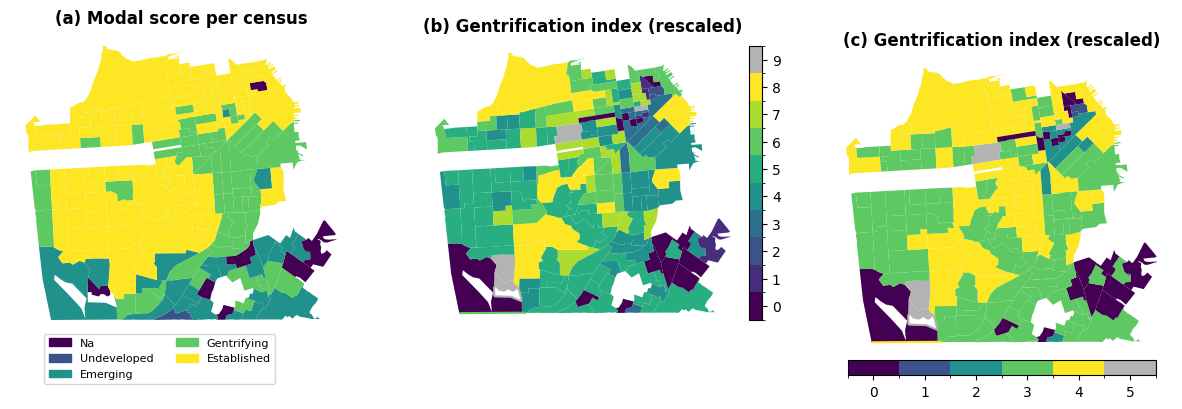

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

####################################################
# PLot 2
####################################################

viridis = plt.get_cmap('viridis', 5)
viridis_colors = viridis(np.arange(5))
custom_colors = np.vstack([viridis_colors, [0.7, 0.7, 0.7, 1]])  # add gray
custom_cmap = mcolors.ListedColormap(custom_colors)

# Set up a BoundaryNorm for discrete mapping (edges between each code)
bounds = np.arange(-0.5, 6, 1)  # 10 bins for values 0–9
norm = mcolors.BoundaryNorm(bounds, ncolors=custom_cmap.N)

# Plot
p0 = per_LSOA_summary.plot('dominant_class', ax=axs[0], legend=False)
axs[0].set_title('(a) Modal score per census', fontweight='bold')
axs[0].axis('off');

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches = [mpatches.Patch(color=per_LSOA_summary.loc[per_LSOA_summary["dominant_class"] == k, "color"].iloc[0], label=label) 
           for k, label in class_labels.items()]
axs[0].legend(handles=patches,loc="upper left", bbox_to_anchor=(0.1, 0), ncol = 2, borderaxespad=0., frameon=True,prop={'size': 8})


# ####################################################
# PLot 2
# ####################################################
viridis = plt.get_cmap('viridis', 9)
viridis_colors = viridis(np.arange(9))
custom_colors = np.vstack([viridis_colors, [0.7, 0.7, 0.7, 1]])  # add gray
custom_cmap = mcolors.ListedColormap(custom_colors)

# Set up a BoundaryNorm for discrete mapping (edges between each code)
bounds = np.arange(-0.5, 10.5, 1)  # 10 bins for values 0–9
norm = mcolors.BoundaryNorm(bounds, ncolors=custom_cmap.N)

# Plot
p0 = gi_clean.plot(ax=axs[1], column='Type_code',cmap=custom_cmap,norm=norm)

# Add colorbar with correct ticks and labels
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm._A = []  # required for matplotlib < 3.1
cb0 = fig.colorbar(sm, ax=axs[1], ticks=np.arange(10), fraction=0.04, pad=0.01)
# cb0.set_label("Type_code")
# cb0.ax.set_yticklabels(list(mapping_gi.keys()))  # Optional: use labels instead of numbers
axs[1].axis('off');
axs[1].set_title("(b) Gentrification index (rescaled)", fontweight='bold');

####################################################
# PLot 3
####################################################
viridis = plt.get_cmap('viridis', 5)
viridis_colors = viridis(np.arange(5))
custom_colors = np.vstack([viridis_colors, [0.7, 0.7, 0.7, 1]])  # add gray
custom_cmap = mcolors.ListedColormap(custom_colors)

# Set up a BoundaryNorm for discrete mapping (edges between each code)
bounds = np.arange(-0.5, 6.5, 1)  # 10 bins for values 0–9
norm = mcolors.BoundaryNorm(bounds, ncolors=custom_cmap.N)

# Plot
p0 = gi_clean.plot(column='Type_code_alternate',cmap=custom_cmap,norm=norm, ax=axs[2])

# Add colorbar with correct ticks and labels
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm._A = []  # required for matplotlib < 3.1
cb0 = fig.colorbar(sm, ax=axs[2], ticks=np.arange(6), fraction=0.04, pad=0.01, location='bottom')
# cb0.set_label("Type_code")
# cb0.ax.set_yticklabels(list(alternate_mapping.keys()))  # Optional: use labels instead of numbers
axs[2].axis('off');
axs[2].set_title("(c) Gentrification index (rescaled)", fontweight='bold');
fig.savefig("../Figures/SanFran_GI-scores.png", bbox_inches = 'tight')

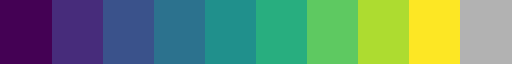

In [143]:
viridis = plt.get_cmap('viridis', 9)
custom_colors = np.vstack([viridis(np.arange(9)), [0.7, 0.7, 0.7, 1]])
custom_cmap = mcolors.ListedColormap(custom_colors)
bounds = np.arange(-0.5, 10.5, 1)
norm = mcolors.BoundaryNorm(bounds, ncolors=custom_cmap.N)
custom_cmap

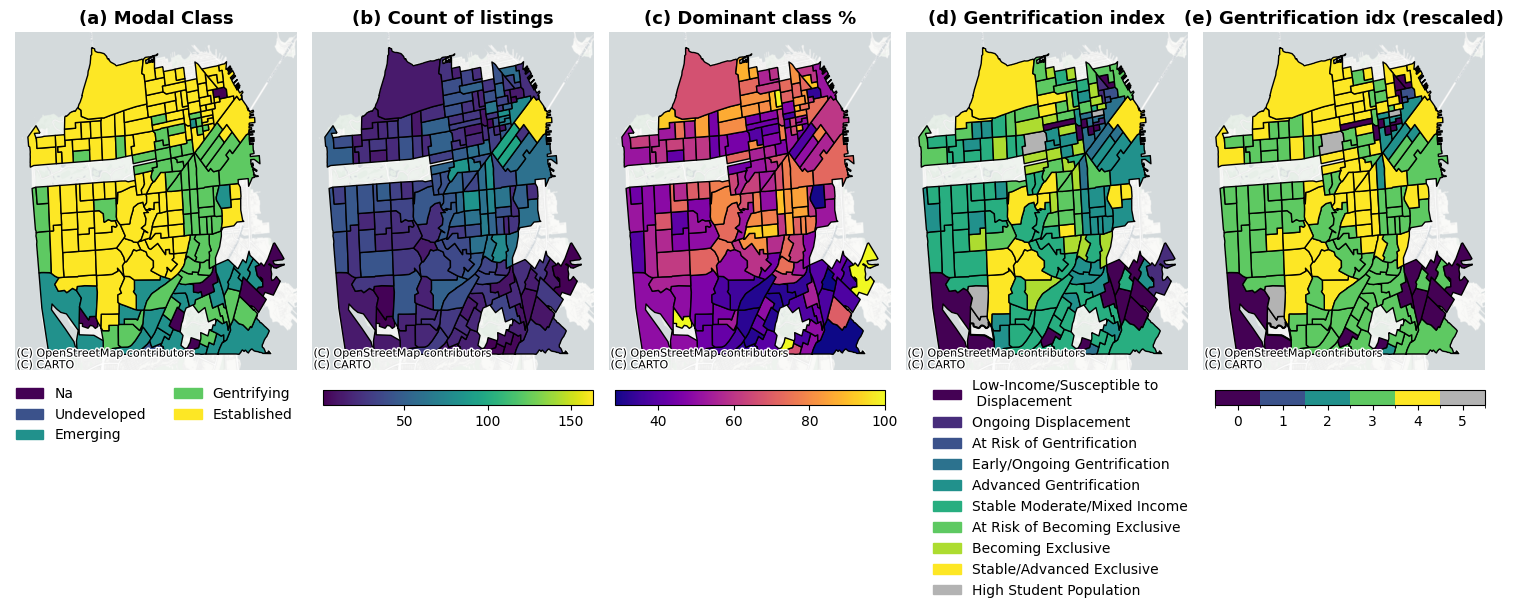

In [146]:
# --- Figure setup ---
fig, axs = plt.subplots(figsize=(15, 5), ncols=5, sharey=True, sharex=True)

# ----------------------------------------------------------
# (a) Modal Class
# ----------------------------------------------------------
mapping = {'Na': 0, 'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
per_LSOA_summary["dominant_class_code"] = per_LSOA_summary["dominant_class"].map(mapping)

modal_cmap = plt.get_cmap("viridis", len(mapping))
p0 = per_LSOA_summary.plot(
    column="dominant_class", cmap=modal_cmap, ax=axs[0],
    edgecolor="black", legend=False)
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class", fontweight="bold", fontsize=13)

# legend patches for modal
modal_patches = [mpatches.Patch(color=modal_cmap(i / len(mapping)), label=label)
    for label, i in mapping.items()]

# ----------------------------------------------------------
# (b) Count of listings
# ----------------------------------------------------------
count_col = "count"
count_cmap = "viridis"
count_vmin, count_vmax = per_LSOA_summary[count_col].min(), per_LSOA_summary[count_col].max()

p1 = per_LSOA_summary.plot(
    count_col, cmap=count_cmap, vmin=count_vmin, vmax=count_vmax,
    ax=axs[1], legend=False, edgecolor="black")
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[1].set_title("(b) Count of listings", fontweight="bold", fontsize=13)

# ----------------------------------------------------------
# (c) % in dominant class
# ----------------------------------------------------------
dom_col = "dominant_pct"
dom_cmap = "plasma"
dom_vmin, dom_vmax = per_LSOA_summary[dom_col].min(), per_LSOA_summary[dom_col].max()

p2 = per_LSOA_summary.plot(
    dom_col, cmap=dom_cmap, vmin=dom_vmin, vmax=dom_vmax,
    ax=axs[2], legend=False, edgecolor="black"
)
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[2].set_title("(c) Dominant class %", fontweight="bold", fontsize=13)

# ----------------------------------------------------------
# (d) Gentrification index (rescaled)
# ----------------------------------------------------------
viridis = plt.get_cmap('viridis', 9)
custom_colors = np.vstack([viridis(np.arange(9)), [0.7, 0.7, 0.7, 1]])
custom_cmap = mcolors.ListedColormap(custom_colors)
bounds = np.arange(-0.5, 10.5, 1)
norm = mcolors.BoundaryNorm(bounds, ncolors=custom_cmap.N)

gi_patches = [mpatches.Patch(color=custom_cmap(i / 9),label=label)
    for i, label in {v: k for k, v in mapping_gi.items()}.items()]

p3 = gi_clean.plot(column='Type_code', cmap=custom_cmap, norm=norm, ax=axs[3], edgecolor='black')
ctx.add_basemap(axs[3], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[3].set_title("(d) Gentrification index", fontweight="bold", fontsize=13)

# ----------------------------------------------------------
# (e) Alternate Type code
# ----------------------------------------------------------
viridis = plt.get_cmap('viridis', 5)
custom_colors = np.vstack([viridis(np.arange(5)), [0.7, 0.7, 0.7, 1]])
custom_cmap = mcolors.ListedColormap(custom_colors)
bounds = np.arange(-0.5, 6.5, 1)
norm = mcolors.BoundaryNorm(bounds, ncolors=custom_cmap.N)

p4 = gi_clean.plot(column='Type_code_alternate', cmap=custom_cmap, norm=norm,
                   edgecolor='black', ax=axs[4])
ctx.add_basemap(axs[4], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[4].set_title("(e) Gentrification idx (rescaled)", fontweight="bold", fontsize=13)
# Add colorbar with correct ticks and labels
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm._A = []  # required for matplotlib < 3.1
# cb0 = fig.colorbar(sm, ax=axs[4], ticks=np.arange(6), fraction=0.04, pad=0.02, location='bottom')


# # ----------------------------------------------------------
# # Clean up and layout
# # ----------------------------------------------------------
for ax in axs:
    ax.axis("off")
    ax.set_aspect("auto")

plt.tight_layout()
fig.subplots_adjust(bottom=0.25)

# # ----------------------------------------------------------
# # Bottom colorbars
# # ----------------------------------------------------------
cbar_ax1 = fig.add_axes([0.215, 0.18, 0.18, 0.03])  # for count [left, bottom, width, height]
cbar_ax2 = fig.add_axes([0.41, 0.18, 0.18, 0.03])  # for dominant %
cbar_ax5 = fig.add_axes([0.81, 0.18, 0.18, 0.03])  # for dominant %

count_norm = mpl.colors.Normalize(vmin=count_vmin, vmax=count_vmax)
dom_norm = mpl.colors.Normalize(vmin=dom_vmin, vmax=dom_vmax)
count_sm = mpl.cm.ScalarMappable(norm=count_norm, cmap=count_cmap)
dom_sm = mpl.cm.ScalarMappable(norm=dom_norm, cmap=dom_cmap)

fig.colorbar(count_sm, cax=cbar_ax1, orientation="horizontal")
fig.colorbar(dom_sm, cax=cbar_ax2, orientation="horizontal")
fig.colorbar(sm, cax=cbar_ax5, ticks=np.arange(6), fraction=0.04, pad=0.02, location='bottom')

# ----------------------------------------------------------
# Legends
# ----------------------------------------------------------
fig.legend(handles=modal_patches, loc="lower left", bbox_to_anchor=(0.002, 0.08),
           ncol=2, frameon=False, prop={"size": 10})
fig.legend(handles=gi_patches, loc="lower right", bbox_to_anchor=(0.8, -0.23),
           ncol=1, frameon=False, prop={"size": 10})

# ----------------------------------------------------------
# Save
# ----------------------------------------------------------
fig.savefig("../Figures/SanFran_Spatial_aligned.png", bbox_inches="tight", dpi=300)
plt.show()

### Calculate entropy for each neighbourhood

In [19]:
# entropy_scores = proportions.apply(entropy, axis=1)
# entropy_scores_df=pd.DataFrame({'geoid':proportions['geoid'], "entropy_scores":entropy_scores})
# entropy_scores_with_geom = census_tracts[['geoid', 'geometry']].merge(entropy_scores_df, on='geoid')
# entropy_scores_with_geom.plot('entropy_scores', legend=True);

### Calculate Kendall's W

Kendall’s W measures the degree of agreement among raters who assign ranks to a set of items. It ranges from 0 (no agreement) to 1 (complete agreement).

In [20]:
# # Step 2: Group all scores by neighbourhood (Keep only those with more than 5 scores
# grouped_scores = (
#     listings_with_geoid
#     .groupby('geoid')
#     .filter(lambda x: len(x) >= 5)
#     .groupby('geoid')['gentrification_prediction_code']
#     .apply(list))

# # Step 4: Define function to compute Kendall’s W (adapted for single-item ratings)
# def kendalls_w(scores):
#     m = len(scores)
#     if m <= 1:
#         return np.nan  # Cannot compute agreement with fewer than 2 raters

#     R_bar = np.mean(scores)
#     S = sum((r - R_bar) ** 2 for r in scores)
#     n = len(mapping)  # Number of possible categories
#     W = 12 * S / (m**2 * (n**2 - 1))
#     return W

# # Step 5: Apply function to each neighbourhood
# kendall_w_per_geo = grouped_scores.apply(kendalls_w).rename("kendalls_w")
# # # Optional: Join back to your polygon GeoDataFrame
# kendall_gdf = census_tracts[['geoid', 'geometry']].merge(kendall_w_per_geo, on='geoid')

In [21]:
# import mapclassify
# kendall_gdf.plot("kendalls_w", cmap="viridis", scheme="quantiles", k=3, legend=True)

### Compare to the index

In [22]:
# gdf_gentrification_idx_bay = gdf_gentrification_idx_bay[gdf_gentrification_idx_bay['gentrification_prediction_code'].notna()] 

### Drop the NA scores for the LLM cats

In [23]:
# scores_and_index = scores_and_index[scores_and_index['gentrification_prediction_code']!=0]

In [24]:
# crosstab = pd.crosstab(gdf_gentrification_idx_bay['gentrification_prediction_code'], gdf_gentrification_idx_bay['Typology_code'])

# plt.figure(figsize=(8, 6))
# sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
# plt.title('Cross-tabulation Heatmap: Displacement index vs LLM Code')
# plt.xlabel('Displacement index code')
# plt.ylabel('LLM code')
# plt.show()

### Normalised to show the percentage of values in that row in each column

In [25]:
# crosstab = pd.crosstab(gdf_gentrification_idx_bay['gentrification_prediction_code'], gdf_gentrification_idx_bay['Typology_code'])
# normalized = crosstab.div(crosstab.sum(axis=1), axis=0).round(2)
# plt.figure(figsize=(8, 6))
# sns.heatmap(normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True)
# plt.title('Normalized Confusion Matrix (row-wise)', fontsize=14)
# plt.xlabel('Index Code')
# plt.ylabel('LLM Code')
# plt.tight_layout()
# plt.show()

In [26]:
# import pandas as pd
# from statsmodels.graphics.mosaicplot import mosaic
# from scipy.stats import chi2_contingency
# import matplotlib.pyplot as plt

# # Cross-tabulation
# crosstab = pd.crosstab(gdf_gentrification_idx_bay['gentrification_prediction_code'], gdf_gentrification_idx_bay['Typology_code'])

# # Optional: ensure square structure
# all_classes = sorted(set(gdf_gentrification_idx_bay['gentrification_prediction_code']) |
#                      set(gdf_gentrification_idx_bay['Typology_code']))
# crosstab = crosstab.reindex(index=all_classes, columns=all_classes, fill_value=0)

In [27]:
# chi2, p, dof, expected = chi2_contingency(crosstab) 
# # Pearson residuals = (observed - expected) / sqrt(expected)
# residuals = (crosstab - expected) / (expected ** 0.5)

In [28]:
# # Convert to dict with tuple keys: (LLM, Index)
# mosaic_data = {
#     (str(int(i)), str(int(j))): crosstab.loc[i, j]
#     for i in crosstab.index
#     for j in crosstab.columns}

# # Color mapping based on residuals
# def props(key):
#     i, j = int(key[0]), int(key[1])
#     r = residuals.loc[i, j]
#     # blue for positive residuals, red for negative, white ~ no deviation
#     if r > 1.96:
#         return {'color': '#2166ac'}  # strong positive
#     elif r < -1.96:
#         return {'color': '#b2182b'}  # strong negative
#     else:
#         return {'color': '#f7f7f7'}  # not significant

In [29]:
# # Suppose these are all possible categories (adjust as needed)
# all_predictions = gdf_gentrification_idx_bay['gentrification_prediction_code'].unique()
# all_classifications = all_classifications = np.arange(1, 9) 

# # Create full cartesian product of all pairs
# full_index = pd.MultiIndex.from_product(
#     [all_predictions, all_classifications],
#     names=['gentrification_prediction_code', 'Typology_code'])

# # Group and count as you did
# mosaic_df = (
#     gdf_gentrification_idx_bay
#     .groupby(['gentrification_prediction_code', 'Typology_code'])
#     .size()
#     .reindex(full_index, fill_value=0)  # fill missing pairs with 0 count
#     .reset_index(name='count'))

# # Rename columns
# mosaic_df.columns = ['gentrification_prediction_code', 'Typology_code', 'count']
# mosaic_df = mosaic_df.sort_values((['gentrification_prediction_code', 'Typology_code']))

# # Then pivot, etc.
# table = mosaic_df.pivot_table(index='gentrification_prediction_code', columns='Typology_code', values='count', aggfunc='sum', fill_value=0)

In [30]:
# import matplotlib.patches as mpatches
# from statsmodels.graphics.mosaicplot import mosaic

# # Define a color for each classification column
# classification_colors = {
#     '1': '#d73027',
#     '2': '#fc8d59',
#     '3': '#fee08b',
#     '4': '#d9ef8b',
#     '5': '#91cf60',
#     '6': '#1a9850',
#     '7': '#4575b4',
#     '8': '#313695'
# }
# def props(key):
#     classification = str(key[1])  # column key
#     color = classification_colors.get(classification, '#f0f0f0')  # fallback color
#     return {'color': color}


In [31]:
# mosaic_data = {
#     (str(row), str(col)): table.loc[row, col]
#     for row in table.index
#     for col in table.columns}

# # Total for percent labels
# total = sum(mosaic_data.values())

# # Label function
# def labelizer(key):
#     pct = mosaic_data[key] / total * 100
#     return f"{pct:.1f}%"

# # Plot
# fig, ax = plt.subplots(figsize=(12, 6))
# mosaic(
#     mosaic_data,
#     labelizer=labelizer,
#     gap=0.02, axes_label=False, properties=props, ax=ax)

# legend_patches = [
#     mpatches.Patch(color=color, label=f'GI {cls}')
#     for cls, color in classification_colors.items()]

# plt.legend(
#     handles=legend_patches,
#     title='Classification',
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left')

# # Extract x/y categories from data
# x_labels = mosaic_df['gentrification_prediction_code'].unique()
# x_labels = ['NA', 'Undeveloped', 'Emerging', 'Gentrifying', 'Established']
# y_labels = mosaic_df['Typology_code'].unique()

# # Set axis ticks manually (adjust positions if necessary)
# # ax.set_xticks([i / len(x_labels) + 0.5 / len(x_labels) for i in range(len(x_labels))])
# ax.set_xticks([0.03,0.13,0.25,0.41,0.77])
# ax.set_xticklabels(x_labels, rotation=0)
# # ax.set_yticks([i / len(y_labels) + 0.5 / len(y_labels) for i in range(len(y_labels))])
# # ax.set_yticklabels(y_labels)

# # Add axis titles
# # ax.set_xlabel('Classification from LLM')
# ax.set_ylabel('Gentrification Index')

# plt.tight_layout()
# plt.show()
